In [33]:
#Load the data for a station and organize for precipitation model
import pandas as pd
import numpy as np
import math
from datetime import datetime
import pyarrow as pa
import pyarrow.parquet as pq
import matplotlib.pyplot as plt

In [3]:
#Paths
#Need to set up based on who is running
usr = "JH"
if usr == "PK":
    ipd01 = "\\\\CXA01\\Users\\jhugh\\Documents\\HT\\NCEI_data\\2024\\"
    ipd02 = "D:\\CodeLibrary\\Python\\weathermetrics\\data\\weathermetrics\\"
    
if usr == "JH":
    ipd01 = "\\\\CXA01\\Users\\jhugh\\Documents\\HT\\NCEI_data\\2024\\"
    ipd02 = "\\\\CXA01\\Users\\jhugh\\Documents\\HT\\NCEI_data\\metrics_csv\\"
    ipd03 = "\\\\CXA01\\Users\\jhugh\\Documents\\Py_S4\\Py_S4_v02_JHH\\NCEI_data\\"



In [4]:
def fn_select_data_vectors_pr07(stid_keys,nstations,nhours,nmonths_row,nmonths_col):
    #Gte the matrix of data to input into marix
    #The S4 model
    # 1. Read in combined data files for multiple stations
    # 2. Find the common dates that will be used to align the matrices
    #    Keep only the values that fit the common starting date 

    # 1. Read in data files and get start date v_date... for each
    # Check that data exist for all metrics

    df_stid = stid_keys
    df_stid2 = df_stid.iloc[:, [0, 3, 4]]  #df_stid[df_stid['target_station'] == stid_target]
    df_stid2 = df_stid2.drop_duplicates() # unique()

    n_rows_stid = min(len(df_stid2),nstations)
    
    #Matrix in which measures are stored
    n_vmt_rows = nhours*30*max(nmonths_row,nmonths_col)
    #vmt_full_set = np.empty(n_vmt_rows,np.float16)
    #is_first = 1
    
    data_list = []
    date_max_list =[]

    #1. Read in data files
    for i in range(0, n_rows_stid):
        infile = ipd03 + str(df_stid2.iloc[i,0]) + "_model_data_combined.csv"
        print(infile)
        df_metrics = pd.read_csv(infile)
        df_metrics['str_hr'] = df_metrics['nHOUR'].apply(lambda x: f'{x:02d}')
        df_metrics['date_hr'] = pd.to_datetime(df_metrics['Date_YYYYMMDD'] + ' ' + df_metrics['str_hr'])
        df_metrics['stid'] = str(df_stid2.iloc[i,0])
        data_list.append(df_metrics)

    #2. Align dates across data files
    for i in range(0, n_rows_stid):
        df = data_list[i]
        max_date = max(df['date_hr'])     
        date_max_list.append(max_date)
    
    date_filter = min(date_max_list)

    for i in range(0, n_rows_stid):
        df = data_list[i]
        #place holder for filtering to a specific end date
        #date_filter = pd.to_datetime("2023-8-11" + ' ' + "17")
        filtered_df = df[df['date_hr'] < date_filter]
        filtered_df = filtered_df.iloc[(len(filtered_df) - n_vmt_rows):len(filtered_df)]
        
        idx_col = filtered_df.columns
        idx_col = str(df_stid2.iloc[i,0]) + '_' + idx_col
        filtered_df.columns = idx_col

        print(filtered_df.shape)
        
        data_list[i] = filtered_df
        
    return data_list[0:n_rows_stid]


In [5]:
def fn_create_data_matrix_pr07(lst_data,tgt_metric,nstations,nmetrics,nmonths_col):
    #Create a matrix for precipitation data that feeds
    #The S4 model
    # 1. Get data list and select target metric
    #Two choices now
    #    - prec
    #    - temp
    # 2.  Create output and move data into approprate cells

    # 1. get data list details and reduce to metrics
    data_vectors_list = []
    dt_rows = len(lst_data[0])
    df00 = []

    dt_rows_minus_1 = dt_rows - 1
    
    if tgt_metric == "prec": tgt_cols = [8,2,3,4,5,6]
    if tgt_metric == "temp": tgt_cols = [8,3,2,4,5,6]
    
    #Reset the indices as all records are ordered by date and hour
    for i in range(nstations):
        df00.append(lst_data[i].iloc[:,tgt_cols])
    
    df01 = [df.reset_index(drop=True) for df in df00]
    rs = pd.concat(df01, axis=1)
    print(rs.shape)
    #print(rs.iloc[1:10,:])
    #Order from most recent to most distant in time
    rs = rs.iloc[::-1]
    #print(rs.iloc[1:10,:])
    
    #2. Create output matrix and move data into appropratie cells
    
    mt_cols = 1 + nstations*nmetrics*nmonths_col*30
    mt_rows = len(rs) - nmonths_col*30*24 - 1
    
    mt_full_set = np.empty((mt_rows,mt_cols ),np.float16)
    
    #rng = mt_rows
    #Set up first column set of data
    tgt_cols = [1,2,3,4,5,7,8,9,10,11,13,14,15,16,17,19,20,21,22,23]
    tgt_cols_num = len(tgt_cols)
    for i in range(0,mt_rows):
        mt_full_set[i,range(0,20)] = rs.iloc[i,tgt_cols]
    

    #Add additional column sets
    nc = nstations*nmetrics
    lpi = mt_rows - nmonths_col*30
    #limit of rows in data set so all marix rows have data
    lpj = nmonths_col*30 - nc  #number of colum sets in columns
    
    for j in range(0,lpj):
        for i in range(0,lpi):
            row_get = i + j + 1
            col_get_start = 0
            col_get_end = nc

            row_put = i
            col_put_start = nc*(j+1)
            col_put_end = col_put_start + nc

            mt_full_set[row_put,col_put_start:col_put_end] = mt_full_set[row_get,col_get_start:col_get_end]
    
    return mt_full_set

In [ ]:
def fn_create_tgt_matrix_pr07(mtx_data,tgt_metric,tgt_mod):
    
    mtx01 = mtx_data
    
    nrows = mtx01.shape[0]
    ncols = mtx01.shape[1]
    
    #1. Modify tgt variable
    # Shift the features down 1 row so they always occur before the tgt
    vc_tgt = mtx01[0:(nrows-1),0].copy()
    mt_feat = mtx01[1:(nrows),0:(ncols)].copy()
    mt_feat[:,0]=vc_tgt
    
    #Modify the target variable depending on the metric (precipitation or temperature)
    #Modify tgt depending on tgt_mod, options could be running totals, moving averages, 
        
    #2. Check that all columns and rows have some type of data
    
    
        
    #return the matrix for analysis
        
    return mt_feat



In [ ]:
#Temp to test fn07
#Parameters governing data matrix
stid_target = "72406093721"
stid_keys = dt_analysis_set_keys
nstations = 4
ipd = ipd02
nhours = 24
ndays = 365
nmonths_row = 144
nmonths_col = 30
nmetrics = 5
tgt_metric =  "temp" #"prec"  "temp"

#1. Get the relevant data in a list
lst_data = fn_select_data_vectors_pr07(stid_keys,nstations,nhours,nmonths_row,nmonths_col)

#2. Construct a matrix from most recent to most distant from the list data
mtx_data = fn_create_data_matrix_pr07(lst_data,tgt_metric,nstations,nmetrics,nmonths_col)

#3.  Create a target variable and select feature variables
s4_data = fn_create_tgt_matrix_pr07(mtx_data,tgt_metric,tgt_mod)





\\CXA01\Users\jhugh\Documents\Py_S4\Py_S4_v02_JHH\NCEI_data\72406093721_model_data_combined.csv
\\CXA01\Users\jhugh\Documents\Py_S4\Py_S4_v02_JHH\NCEI_data\72405013743_model_data_combined.csv
\\CXA01\Users\jhugh\Documents\Py_S4\Py_S4_v02_JHH\NCEI_data\74594493784_model_data_combined.csv
\\CXA01\Users\jhugh\Documents\Py_S4\Py_S4_v02_JHH\NCEI_data\72403093738_model_data_combined.csv
(103680, 10)
(103680, 10)
(103680, 10)
(103680, 10)
(103680, 24)


(array([  985.,   837.,  1128.,  2008.,  2012.,  2382.,  1517.,  6986.,
         5977., 12166., 12451., 14820., 14008.]),
 array([-1.0e+00,  0.0e+00,  1.0e-02,  1.0e+00,  2.0e+00,  3.0e+00,
         4.0e+00,  5.0e+00,  7.5e+00,  1.0e+01,  1.5e+01,  2.0e+01,
         2.5e+01,  5.0e+01]),
 <BarContainer object of 13 artists>)

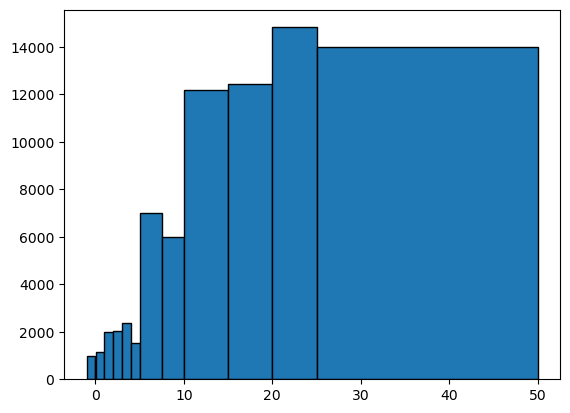

In [46]:
x = s4_data
bin_edges = [-1,0,0.01,1,2,3,4,5,7.5,10,15,20,25,50]
plt.hist(x[:,0],bins=bin_edges,edgecolor='black')

In [ ]:
# data = {
#     'st_id': [72508014740,72508014740,72508014740, 72504094702,72504094702,72504094702,72510094746,72510094746,72510094746,72505004781,72505004781,72505004781],
#     'target_station': [72508014740,72508014740,72508014740,72508014740,72508014740,72508014740,72508014740,72508014740,72508014740,72508014740,72508014740,72508014740],
#     'fnames': ['72508014740_model_data_airtemp.csv', '72508014740_model_data_precip.csv', '72508014740_model_data_relhum.csv',
#         '72504094702_model_data_airtemp.csv', '72504094702_model_data_precip.csv', '72504094702_model_data_relhum.csv',
#         '72510094746_model_data_airtemp.csv', '72510094746_model_data_precip.csv', '72510094746_model_data_relhum.csv',
#         '72505004781_model_data_airtemp.csv', '72505004781_model_data_precip.csv', '72505004781_model_data_relhum.csv'],
#     'path': ['D:\\CodeLibrary\\Python\\weathermetrics\\data\\weathermetrics\\',
#             'D:\\CodeLibrary\\Python\\weathermetrics\\data\\weathermetrics\\',
#             'D:\\CodeLibrary\\Python\\weathermetrics\\data\\weathermetrics\\',
#             'D:\\CodeLibrary\\Python\\weathermetrics\\data\\weathermetrics\\',
#             'D:\\CodeLibrary\\Python\\weathermetrics\\data\\weathermetrics\\',
#             'D:\\CodeLibrary\\Python\\weathermetrics\\data\\weathermetrics\\',
#             'D:\\CodeLibrary\\Python\\weathermetrics\\data\\weathermetrics\\',
#             'D:\\CodeLibrary\\Python\\weathermetrics\\data\\weathermetrics\\',
#             'D:\\CodeLibrary\\Python\\weathermetrics\\data\\weathermetrics\\',
#             'D:\\CodeLibrary\\Python\\weathermetrics\\data\\weathermetrics\\',
#             'D:\\CodeLibrary\\Python\\weathermetrics\\data\\weathermetrics\\',
#             'D:\\CodeLibrary\\Python\\weathermetrics\\data\\weathermetrics\\'],
#     'vect_close_bkt2': [1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4]
# }

# dt_analysis_set_keys = pd.DataFrame(data)
# dt_analysis_set_keys

In [7]:
#STEP 1.  Select a station using ID to get its related stations
# Get file of target stations and their related stations
dt_trg_set = ipd02 + "Target_station_analysis_set.csv"
lst_target_stations = [
  "74486094789",
  "72518014735",
  "72508014740",
  "72526014860",
  "72406093721",
  "72401013740",
  "72219013874",
  "72423093821",
  "72428014821",
  "72327013897"
]

#Select the target station for which predictions will be made
#72508014740 is JFK airport
st_id = lst_target_stations[4]
num_st_keep = 4   #num of stations to keep for analysis
analysis_set = dt_trg_set
dt_analysis_set = pd.read_csv(analysis_set)
dt_analysis_set['path'] = ipd02
dt01 = dt_analysis_set[dt_analysis_set['target_station']==int(st_id)]
#uniq_stat = dt01['vect_close_bkt2'].unique()[:2]
uniq_station = dt01['st_id'].unique()[:num_st_keep]
dt02 = dt01[dt01['st_id'].isin(uniq_station)]

selected_columns = ['st_id','target_station',
                    'fnames','path','vect_close_bkt2']
#The output below is fed to STEP 2 to run the analysis
dt_analysis_set_keys = dt02[selected_columns].copy()

dt_analysis_set_keys

,st_id,target_station,fnames,path,vect_close_bkt2
207,72406093721,72406093721,72406093721_model_data_airtemp.csv,\\CXA01\Users\jhugh\Documents\HT\NCEI_data\met...,1
208,72406093721,72406093721,72406093721_model_data_precip.csv,\\CXA01\Users\jhugh\Documents\HT\NCEI_data\met...,1
209,72406093721,72406093721,72406093721_model_data_relhum.csv,\\CXA01\Users\jhugh\Documents\HT\NCEI_data\met...,1
210,72405013743,72406093721,72405013743_model_data_airtemp.csv,\\CXA01\Users\jhugh\Documents\HT\NCEI_data\met...,2
211,72405013743,72406093721,72405013743_model_data_precip.csv,\\CXA01\Users\jhugh\Documents\HT\NCEI_data\met...,2
212,72405013743,72406093721,72405013743_model_data_relhum.csv,\\CXA01\Users\jhugh\Documents\HT\NCEI_data\met...,2
213,74594493784,72406093721,74594493784_model_data_airtemp.csv,\\CXA01\Users\jhugh\Documents\HT\NCEI_data\met...,2
214,74594493784,72406093721,74594493784_model_data_precip.csv,\\CXA01\Users\jhugh\Documents\HT\NCEI_data\met...,2
215,74594493784,72406093721,74594493784_model_data_relhum.csv,\\CXA01\Users\jhugh\Documents\HT\NCEI_data\met...,2
216,72403093738,72406093721,72403093738_model_data_airtemp.csv,\\CXA01\Users\jhugh\Documents\HT\NCEI_data\met...,3


In [ ]:
#STEP 2.  Use elements created in STEP 1 to get a data matrix for analysis
#All the available stations which have all three metrics needed for model
#vc_stid = dt_analysis_set_keys[['st_id']].drop_duplicates()

#Organize the data based on the nature of the data so they all conform to the same size matrices
#The metrics included are
#  AT - air temperature in Celcius
#  RH - relative humidity in Percent
#  PR - precipitation in MM

#Put them all in appropriate matrices and create list of metrics
#Data files are of two types
#    -  24 hour * 365 days * n years  (AT, PR)
#    -  365 days * n years (RH)

#Parameters governing data matrix
in_data = dt_analysis_set_keys
in_nstations = 2
in_path = ipd02
nhours = 24
ndays = 365
nyears_row = 5
nyears_col = 2
n_metrics = 5

print(ipd02)
rtn_matrix = fn_make_matrix_pr06(in_data,in_nstations,in_path,nhours,ndays,nyears_row,nyears_col,n_metrics)
rtn_mtx_pqt = pd.DataFrame(rtn_matrix)
fn = f"{ipd02}{st_id}_{in_nstations}st_{nyears_row}RYr_{nyears_col}CYr.parquet"
rtn_mtx_pqt.to_parquet(fn, index=False)



In [ ]:
def XREMfn_make_matrix(vc_measure,offset_measure,nhours,ndays,nyears_col,nyears_row):
    #the offset from the start of the vector to align the data points
    vector = vc_measure

    nrows = nhours*ndays*nyears_row   #the number of values put in each row of matrix days*hours*years
    ncols = nhours*ndays*nyears_col   #the number of values put in each row of matrix days*hours*years
    
    # Create an empty matrix to store the results
    matrix = np.zeros((nrows, ncols))

    # Fill the matrix
    for i in range(nrows):
        matrix[i] = vector[(offset_measure + i):(offset_measure + i + ncols)]
     
    return matrix
    

In [ ]:
def transform_matrix(df, bins, labels):
    """
    Transforms the given matrix by binning the first column, dropping the first row and column,
    and adding the binned column as the first column.

    Parameters:
        matrix (pd.DataFrame): The input matrix.

    Returns:
        pd.DataFrame: The transformed matrix.
    """
    # Extract the first column (dependent variable)
    firstcolumn = df.iloc[:, 0].astype('float32')

    # Bin the first column
    binned_column = pd.cut(firstcolumn, bins=bins, labels=labels)

    # Drop the first first column
    df = df.iloc[:, 1:]

    # Add the binned column as the first column
    df.insert(0, 0, binned_column.iloc[0:].values)

    # Return the final matrix
    return df

# Example usage
# Example matrix (replace this with your actual matrix)
jj   = rtn_matrix
df = pd.DataFrame(jj).iloc[1:,] # Convert to DataFrame and drop the first row for binning
# Drop rows where the first column has missing values
# df = df.dropna(subset=[0])
fc = df.iloc[:,0].astype('float32') # Ensure the first column is float for binning
#DEL#bins = [-float('inf'), 10, 20, 25, float('inf')]

bins = [-float('inf'), 1, float('inf')]
# bins = [-float('inf'), 0] + list(pd.qcut(fc[fc > 0], q=4, retbins=True)[1][1:]) + [float('inf')]
labels = [0, 1]
# print(bins, labels)


# bins = [-float('inf'), 0] + list(pd.qcut(fc[fc > 0], q=4, retbins=True)[1][1:]) + [float('inf')]
#labels = [0, 1, 2, 3]
# print(bins, labels)

df_transformed = transform_matrix(df, bins, labels)
df_transformed = df_transformed[df_transformed[0]>= 0]
print("Dataset: ", df_transformed.shape)
df_transformed[0].value_counts(dropna=False).sort_index()

In [ ]:
def split_time_series_data(df, train_ratio=0.7, val_ratio=0.1, test_ratio=0.2):
    """
    Splits a time series dataset into training, validation, and test sets.

    Parameters:
        df (pd.DataFrame): The input time series dataset, ordered in descending dates.
        train_ratio (float): The proportion of data to use for training.
        val_ratio (float): The proportion of data to use for validation.
        test_ratio (float): The proportion of data to use for testing.

    Returns:
        tuple: A tuple containing three DataFrames (train, validation, test).
    """
    assert train_ratio + val_ratio + test_ratio == 1.0, "Ratios must sum to 1.0"

    # Calculate split indices
    n = len(df)
    test_end = int(n * test_ratio)    
    val_end = test_end + int(n * val_ratio)
    

    # Split the data
    test_data = df.iloc[:test_end].sort_index(ascending=False)
    val_data = df.iloc[test_end:val_end].sort_index(ascending=False)
    train_data = df.iloc[val_end:].sort_index(ascending=False)


    return train_data, val_data, test_data

# Example usage
train_data, val_data, test_data = split_time_series_data(df_transformed)
print("Training Set:", train_data.shape)
print(train_data[0].value_counts(dropna=False).sort_index())
print("Validation Set:", val_data.shape)
print(val_data[0].value_counts(dropna=False).sort_index())
print("Test Set:", test_data.shape)
print(test_data[0].value_counts(dropna=False).sort_index())

In [ ]:
# Define the station ID and output directory
station_id = st_id
#output_dir = "D:\\CodeLibrary\\Python\\weathermetrics\\data\\weathermetrics\\"
output_dir = ipd02


# Export datasets to CSV
train_data.to_parquet(f"{output_dir}{station_id}_train.parquet", index=False)
val_data.to_parquet(f"{output_dir}{station_id}_validation.parquet", index=False)
test_data.to_parquet(f"{output_dir}{station_id}_test.parquet", index=False)

# train_data.to_csv(f"{output_dir}{station_id}_train.csv", index=False)
# val_data.to_csv(f"{output_dir}{station_id}_validation.csv", index=False)
# test_data.to_csv(f"{output_dir}{station_id}_test.csv", index=False)

print("Datasets exported successfully.")

#python -m s4model --modelname 72508014740 --trainset ../data/weathermetrics/72508014740_train.csv --valset ../data/weathermetrics/72508014740_validation.csv --testset ../data/weathermetrics/72508014740_test.csv --tabulardata --dependent_variable 0 --epochs 30

#python -m s4model --modelname 72508014740 --trainset \\\\CXA01\\Users\\jhugh\\Documents\\HT\\NCEI_data\\metrics_csv\\72508014740_train.parquet --valset \\\\CXA01\\Users\\jhugh\\Documents\\HT\\NCEI_data\\metrics_csv\\72508014740_validation.parquet --testset \\\\CXA01\\Users\\jhugh\\Documents\\HT\\NCEI_data\\metrics_csv\\72508014740_test.parquet --tabulardata --dependent_variable 0 --epochs 30

# python -m charts --df ../results/72508014740_Test_results_20250424_104121PM.csv --actual 0 --predicted Predicted 
# python -m charts --df ../results/72508014740_Test_results_20250427_100132PM.csv --actual 0 --predicted Predicted 
# python -m charts --df ../results/72508014740_Test_results_20250428_091259PM.csv --actual 0 --predicted Predicted 
# python -m charts --df ../results/72508014740_Test_results_20250428_094033PM.csv --actual 0 --predicted Predicted 
# python -m charts --df ../results/72508014740_Test_results_20250429_091538PM.csv --actual 0 --predicted Predicted

Datasets exported successfully.


In [ ]:
st_id
ipd02
python -m charts --df ../results/72508014740_Test_results_20250527_093455PM.csv --actual 0 --predicted Predicted

'\\\\CXA01\\Users\\jhugh\\Documents\\HT\\NCEI_data\\metrics_csv\\'

In [ ]:
# def find_first_non_nan(vector):
#     return next((i for i, x in enumerate(vector) if not math.isnan(x)), None)

# first_number_at1 = find_first_non_nan(vc_at1)
# first_number_rh1 = find_first_non_nan(vc_rh1)
# first_number_rh2 = find_first_non_nan(vc_rh2)
# first_number_rh3 = find_first_non_nan(vc_rh3)
# first_number_pr1 = find_first_non_nan(vc_pr1)

# #Number of missing data points
# print(f"AT1 Number of missing cells: {np.count_nonzero(np.isnan(vc_at1))}")
# print(f"AT1 Vector Length: {len(vc_at1)}")

# print(f"RH1 Number of missing cells: {np.count_nonzero(np.isnan(vc_rh1))}")
# print(f"RH1 Vector Length: {len(vc_rh1)}")

# print(f"PR1 Number of missing cells: {np.count_nonzero(np.isnan(vc_pr1))}")
# print(f"PR1 Vector Length: {len(vc_pr1)}")

# #Once a day metrics
# v_data_first_once_day = max(
#                    first_number_rh1,
#                    first_number_rh2,
#                    first_number_rh3)
# print(v_data_first_once_day)

# #24 times a day metrics
# v_data_first_24h_day = max(first_number_at1,
#                    first_number_pr1)
# print(v_data_first_24h_day)


#These vectors all start with a numeric value so missing values can be filled


#print(first_number_at1)
#print(first_number_rh1)
#print(first_number_rh2)
#print(first_number_rh3)
#print(first_number_pr1)



In [ ]:
df = pd.DataFrame(jj)
fc = df.iloc[:,0].astype('float32')
print(fc.shape)
import matplotlib.pyplot as plt

plt.hist(fc, bins=50, color='blue', alpha=0.7, density=True)
plt.title('Normalized Histogram of a')
plt.xlabel('Value')
plt.ylabel('Density')
plt.show()

In [ ]:
# Custom bins

a = fc[~fc.isnull()]

# Calculate min, max, and percentiles by 10 for 'a'
min_val = a.min()
max_val = a.max()
percentiles = np.percentile(a, np.arange(0, 101, 10))

print(f"Min: {min_val}")
print(f"Max: {max_val}")
print(f"Percentiles: {percentiles}")
